## Quantitative Portfolio Analysis & Optimization

This project implements a complete quantitative research pipeline for equity analysis and portfolio optimization. It downloads market data, computes asset-level and portfolio-level risk metrics, generates visualizations, optimizes portfolio weights using Mean-Variance (Max Sharpe Ratio), and forecasts portfolio value using an ARIMA time-series model.

### Importing Modules

This cell imports all functions and configuration variables,

- Data loading  
- Metrics computation  
- Optimization  
- Visualization  
- Forecasting  
- Database storage  


In [21]:
import pandas as pd

from modules.optimizer import max_sharpe_weights
from modules.db_handler import get_connection, save_dataframe
from modules.forecasting import forecast_portfolio_arima, plot_forecast
from modules.data_loader import fetch_price_data, compute_daily_returns
from modules.config import (
    TICKERS,
    BENCHMARK_TICKER,
    START_DATE,
    END_DATE,
    RISK_FREE_RATE,
)
from modules.risk_metrics import (
    asset_metrics_table,
    benchmark_metrics_table,
    portfolio_metrics_table,
)
from modules.visualizations import (
    plot_correlation_matrix,
    plot_drawdown_from_prices,
    plot_optimal_weights,
    plot_prices,
    plot_returns_hist,
    plot_rolling_volatility,
)


### Loading Market Data

This step:
- Downloads price data for assets & benchmark  
- Cleans and aligns the time series  
- Computes daily returns  

Outputs:
- `prices` → cleaned price data  
- `asset_returns` → daily % returns of each stock  
- `benchmark_returns` → benchmark (NIFTY) returns  


In [22]:
prices, benchmark_prices = fetch_price_data(
    TICKERS, BENCHMARK_TICKER, start=START_DATE, end=END_DATE
)

asset_returns, benchmark_returns = compute_daily_returns(prices, benchmark_prices)

prices.head(), benchmark_prices.head()


[*********************100%***********************]  6 of 6 completed


(Ticker           TCS.NS     INFY.NS  HDFCBANK.NS  RELIANCE.NS  ICICIBANK.NS
 Date                                                                       
 2015-01-02  1020.265259  374.998016   220.258682   189.496948    302.369690
 2015-01-05  1004.760193  371.775665   218.399048   187.421265    302.995636
 2015-01-06   967.717957  364.008118   214.999207   178.915253    290.143005
 2015-01-07   956.287109  365.749786   215.626740   182.809814    282.297974
 2015-01-08   966.610840  367.593842   220.156036   180.188507    289.976135,
 Date
 2015-01-02    8395.450195
 2015-01-05    8378.400391
 2015-01-06    8127.350098
 2015-01-07    8102.100098
 2015-01-08    8234.599609
 Name: ^NSEI, dtype: float64)

### Portfolio Optimization (Max Sharpe Ratio)

In this step:
- We compute the optimal weights using Mean-Variance Optimization  
- The objective is to maximize the Sharpe Ratio
- We then construct portfolio returns and cumulative portfolio value  

Outputs:
- `weights_series` → optimized weights  
- `portfolio_prices` → portfolio value curve  


In [23]:
weights = max_sharpe_weights(asset_returns, rf=RISK_FREE_RATE)
weights_series = pd.Series(weights, index=TICKERS, name="Weight")

portfolio_returns = (asset_returns * weights).sum(axis=1)
portfolio_prices = (1 + portfolio_returns).cumprod()
portfolio_prices.name = "Portfolio"

weights_series

TCS.NS          0.105549
INFY.NS         0.195365
HDFCBANK.NS     0.269014
RELIANCE.NS     0.350768
ICICIBANK.NS    0.079305
Name: Weight, dtype: float64

### Computing Risk & Performance Metrics

For:
- Individual assets  
- Benchmark  
- Optimized portfolio  

Metrics include:
- Sharpe / Sortino  
- Volatility  
- Max drawdown  
- Beta, Alpha, R²  
- VaR, CVaR  


In [24]:
asset_metrics = asset_metrics_table(
    prices, asset_returns, benchmark_returns, rf=RISK_FREE_RATE
)

benchmark_metrics = benchmark_metrics_table(benchmark_prices, benchmark_returns)

portfolio_metrics = portfolio_metrics_table(
    portfolio_prices,
    portfolio_returns,
    benchmark_prices,
    benchmark_returns,
    rf=RISK_FREE_RATE,
)

asset_metrics, benchmark_metrics, portfolio_metrics


(          Asset  1D Return  5D Return  1M Return  3M Return  6M Return  \
 0        TCS.NS   0.002787   0.032096   0.075492   0.049933  -0.032569   
 1       INFY.NS   0.011642   0.035959   0.101930   0.121628   0.055743   
 2   HDFCBANK.NS   0.006117  -0.004268   0.018941   0.043745   0.043149   
 3   RELIANCE.NS   0.003256  -0.017161   0.029744   0.133377   0.072347   
 4  ICICIBANK.NS   0.004183   0.002664   0.054605  -0.009249  -0.035438   
 
     1Y CAGR   3Y CAGR   5Y CAGR  Standard Deviation (Ann.)  ...  \
 0 -0.221233  0.017709  0.068335                   0.233024  ...   
 1 -0.120538  0.032116  0.113545                   0.264676  ...   
 2  0.113576  0.084905  0.117565                   0.222299  ...   
 3  0.168860  0.091908  0.125958                   0.272373  ...   
 4  0.072489  0.160255  0.280961                   0.305742  ...   
 
    Alpha Skewness  Alpha Kurtosis  Mean Alpha on Stress Days  VaR 1D @95%  \
 0        0.251760        5.559588                   0.00039

### Generating Plots

Visual analytics generated:
- Price chart  
- Returns histogram  
- Rolling volatility  
- Portfolio & benchmark drawdowns  
- Correlation heatmap  
- Optimizer weight bar chart   


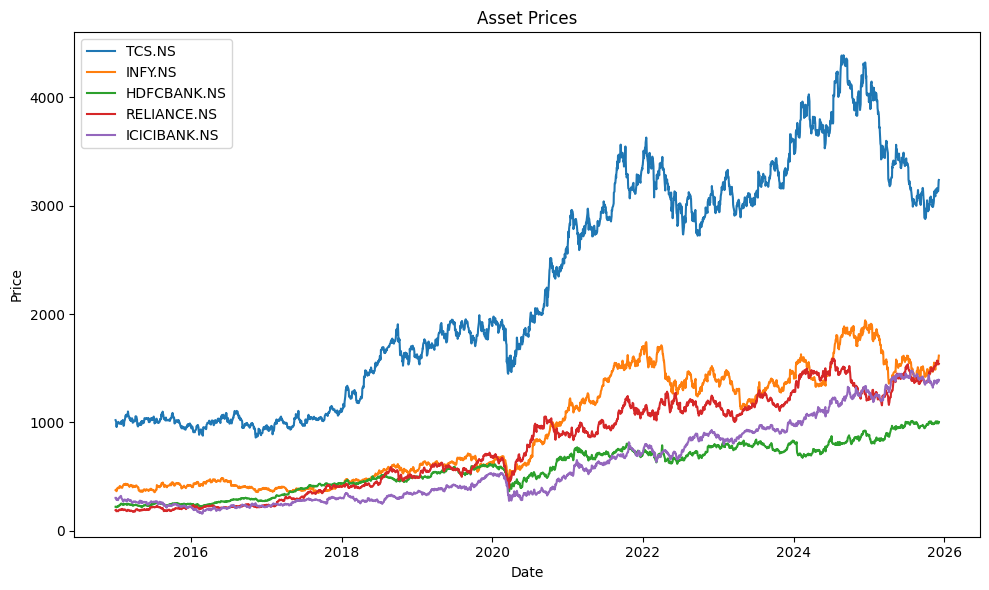

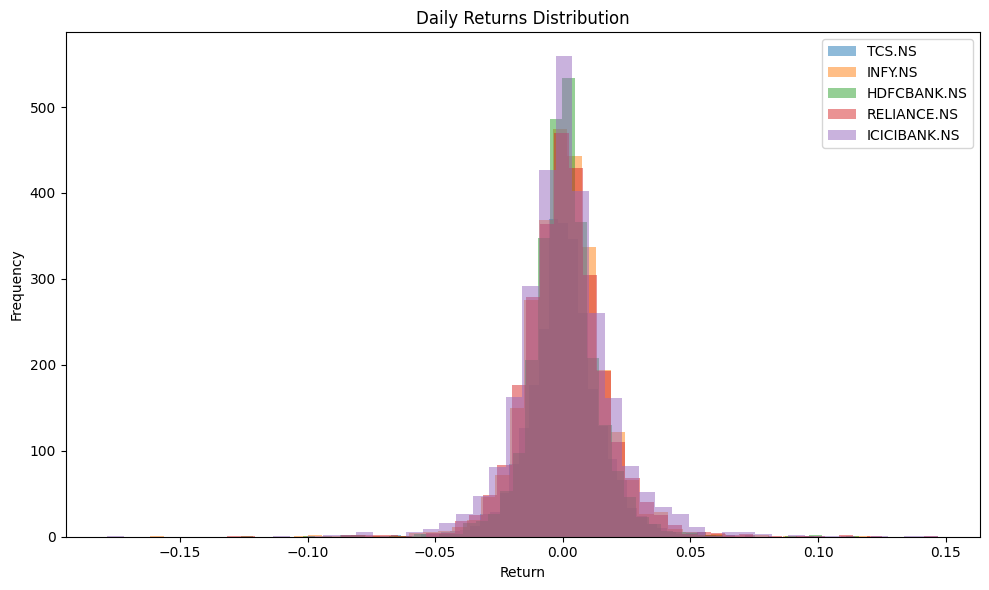

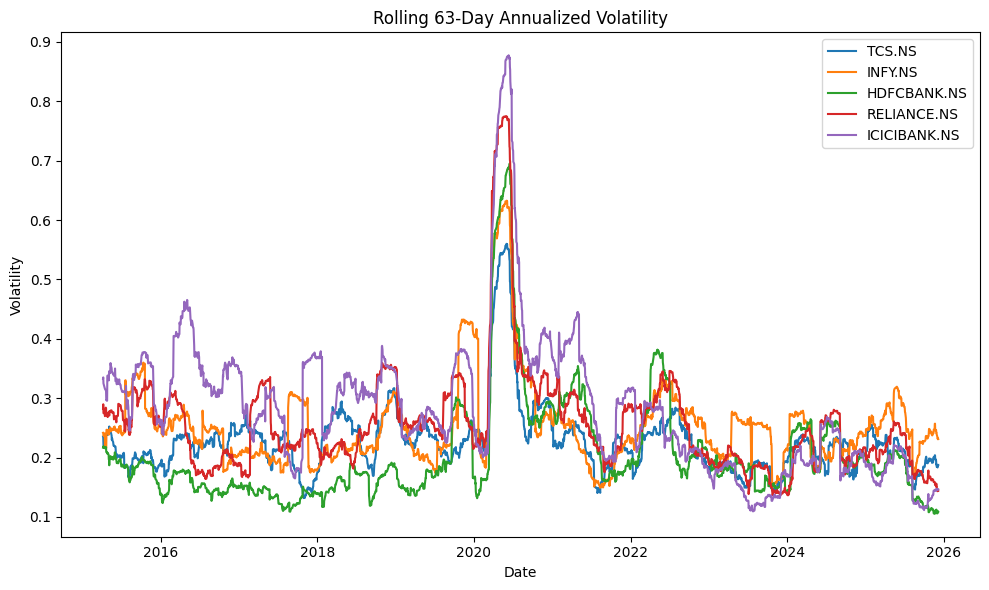

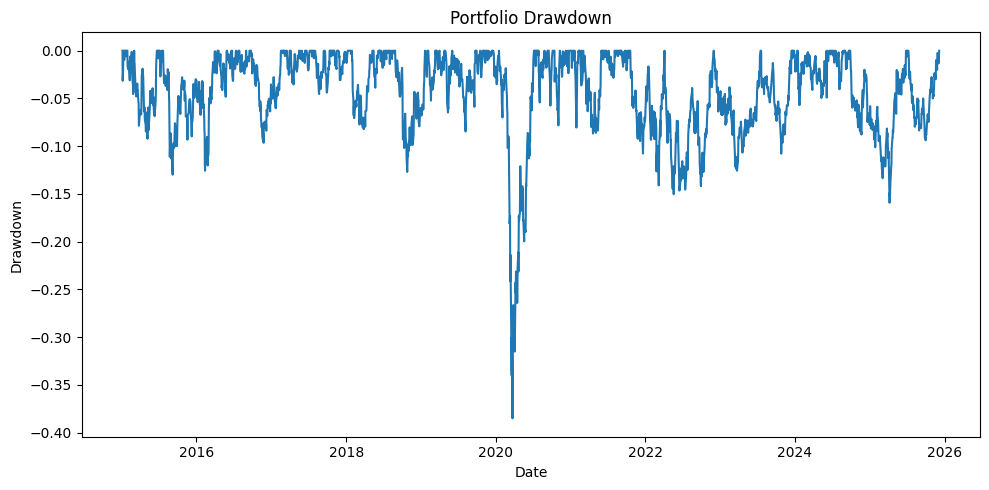

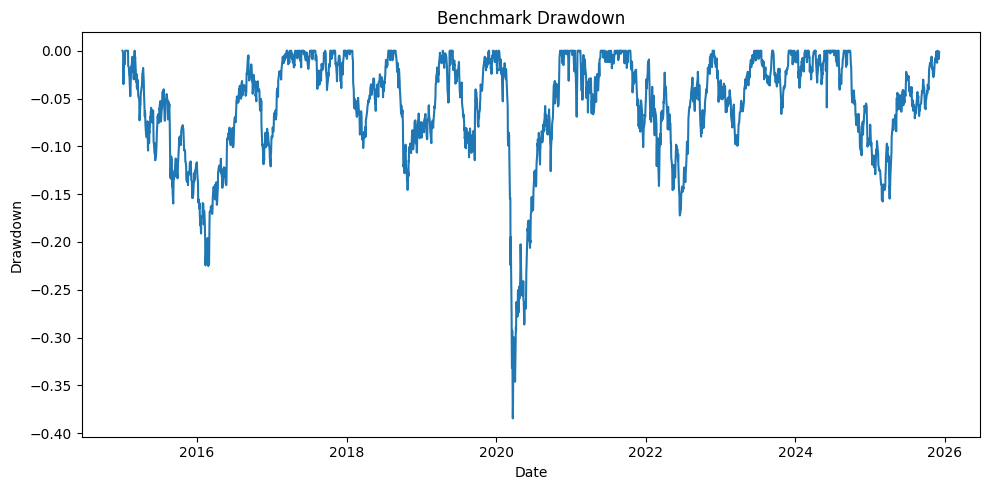

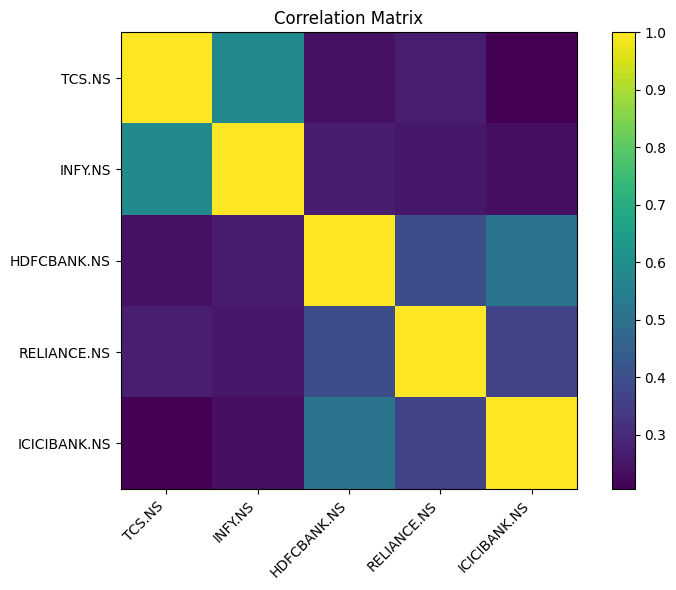

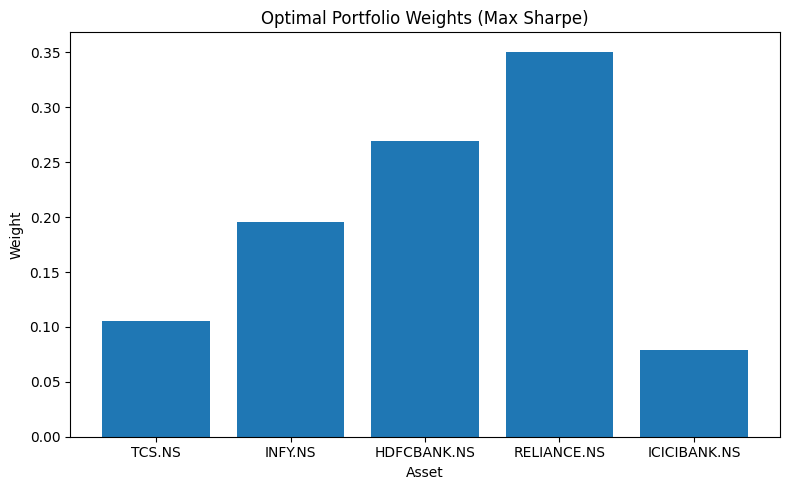

All plots saved successfully.


In [25]:
plot_prices(prices, "plots/prices/asset_prices.png")
plot_returns_hist(asset_returns, "plots/returns/asset_returns_hist.png")

plot_rolling_volatility(
    asset_returns,
    window=63,
    save_path="plots/volatility/rolling_vol_63d.png"
)

plot_drawdown_from_prices(
    portfolio_prices,
    "Portfolio Drawdown",
    "plots/drawdowns/portfolio_drawdown.png",
)

plot_drawdown_from_prices(
    benchmark_prices,
    "Benchmark Drawdown",
    "plots/drawdowns/benchmark_drawdown.png",
)

plot_correlation_matrix(asset_returns, "plots/correlations/correlation_matrix.png")

plot_optimal_weights(
    TICKERS,
    weights,
    "plots/optimizer/optimal_weights.png",
)

print("All plots saved successfully.")


### ARIMA Forecasting

We model the future portfolio value using:
- ARIMA(1,1,1)
- Forecast horizon: 90 days 


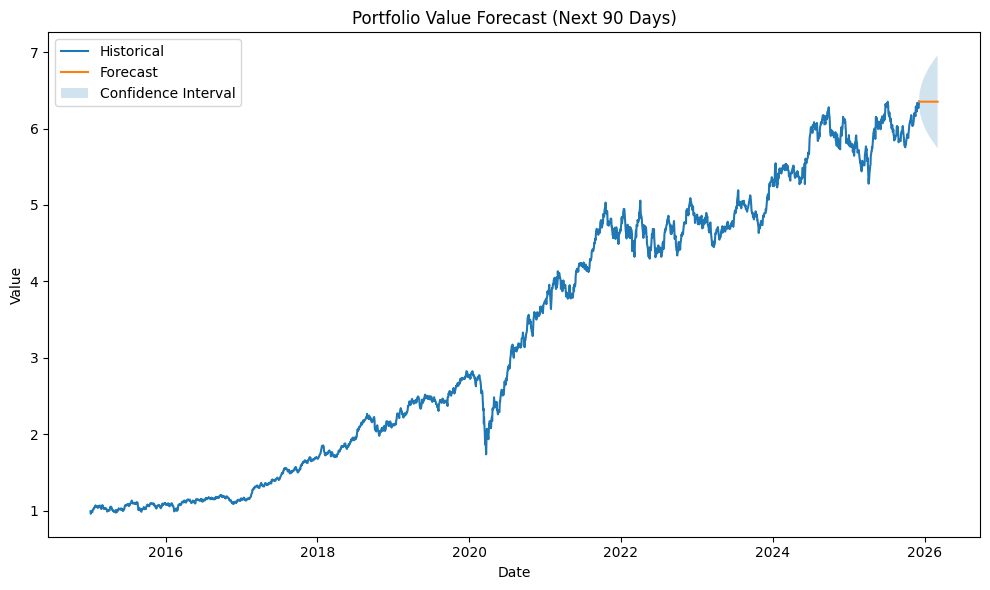

,forecast,lower_ci,upper_ci
2025-12-06,6.350589,6.284076,6.417101
2025-12-07,6.351161,6.259403,6.442919
2025-12-08,6.350979,6.238956,6.463001
2025-12-09,6.351037,6.222057,6.480016
2025-12-10,6.351018,6.207018,6.495018


In [26]:
forecast_df = forecast_portfolio_arima(portfolio_prices, steps=90)

plot_forecast(
    portfolio_prices,
    forecast_df,
    "plots/forecast/portfolio_forecast.png",
    title="Portfolio Value Forecast (Next 90 Days)",
)

forecast_df.head()


### Saving all results to SQLite database

We store:
- Prices  
- Returns  
- All metrics  
- Optimized weights  
- Correlation matrix  
- Forecast data  


In [27]:
conn = get_connection("db/analytics.db")

save_dataframe(conn, prices, "asset_prices", index_label="date")
save_dataframe(conn, benchmark_prices.to_frame("Benchmark"), "benchmark_prices", index_label="date")
save_dataframe(conn, asset_returns, "asset_returns", index_label="date")
save_dataframe(conn, benchmark_returns.to_frame("Benchmark"), "benchmark_returns", index_label="date")

save_dataframe(conn, asset_metrics, "asset_metrics")
save_dataframe(conn, benchmark_metrics, "benchmark_metrics")
save_dataframe(conn, portfolio_metrics, "portfolio_metrics")

save_dataframe(conn, weights_series.to_frame(), "optimization_results", index_label="asset")

corr = asset_returns.corr()
save_dataframe(conn, corr, "correlation_matrix")

save_dataframe(conn, forecast_df, "portfolio_forecast", index_label="date")

conn.close()

print("Database saved successfully.")

Database saved successfully.


### Final Portfolio Summary

- Optimal weights  
- Annual return  
- Annual volatility  
- Sharpe ratio  

In [28]:
print("\nOptimal Weights (Max Sharpe):")
for asset, w in weights_series.items():
    print(f"{asset}: {w:.4f}")

print("\nPortfolio Summary:")
ann_ret = portfolio_returns.mean() * 252
ann_vol = portfolio_returns.std() * (252 ** 0.5)
sharpe = ann_ret / ann_vol if ann_vol > 0 else float("nan")

print(f"Annual Return: {ann_ret:.4f}")
print(f"Annual Volatility: {ann_vol:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")

print("\nDone — all analytics saved!")


Optimal Weights (Max Sharpe):
TCS.NS: 0.1055
INFY.NS: 0.1954
HDFCBANK.NS: 0.2690
RELIANCE.NS: 0.3508
ICICIBANK.NS: 0.0793

Portfolio Summary:
Annual Return: 0.1897
Annual Volatility: 0.1809
Sharpe Ratio: 1.0483

Done — all analytics saved!
